# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: June 08, 2021
Pyleecan version:1.3.1
SciDataTool version:1.4.1


# How to define a Parameter Sweep of a Variable speed simulation?
This tutorial explains how to use the object VarParam and VarLoadCurrent to run Parameter Sweep of a Variable speed simulation by using the multi-simulation tools of pyleecan. This tutorial combines several advanced aspect of pyleecan, please read the following tutorials first:

- "[How to define a machine](https://pyleecan.org/tuto_Machine.html)"
- "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)".
- "[How to set the Operating Point](https://pyleecan.org/tuto_Operating_point.html)".
- "[How to run a multi-simulation](https://pyleecan.org/tuto_multisimulation.html)".

The multi-simulation tools of Pyleecan can be combined to create multi-simulation of multi-simulation. This tutorial will build step by step (or layer by layer) a parameter sweep to study the impact of the stator slot opening of the Toyota Prius on the variable speed torque. 

## Machine and Reference Simulation definition
The first step is to define the reference simulation aka the original machine without any modifications from the VarParam (Parameter sweep object) nor the VarLoadCurrent (Variable speed object). This tutorial uses the usual machine Toyota_Prius (2004) and simulation from the previous tutorials:

<IPython.core.display.Javascript object>


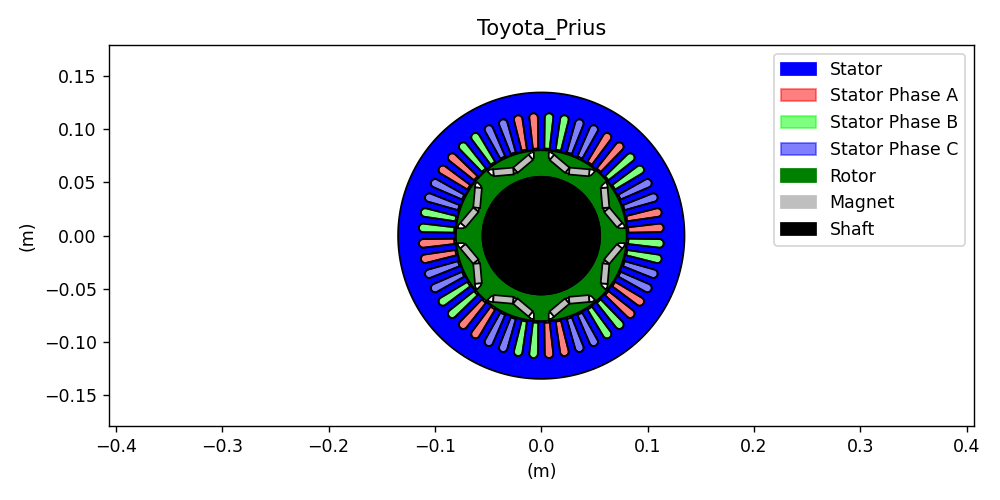

In [2]:
%matplotlib notebook

# Load the machine
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from os.path import join

Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
Toyota_Prius.plot()

In [4]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from numpy import sqrt, pi
# Initialization of the Simulation
simu_ref = Simu1(name="tuto_multi", machine=Toyota_Prius)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu_ref.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    Kgeo_fineness=1,
)
# Run only Magnetic module
simu_ref.elec = None
simu_ref.force = None
simu_ref.struct = None
# Set reference simulation operating point
simu_ref.input = InputCurrent()
simu_ref.input.set_Id_Iq(I0=250/sqrt(2), Phi0=140*pi/180)
simu_ref.input.Tem_av_ref = 353
simu_ref.input.Nt_tot = 128 # Number of time step
simu_ref.input.Na_tot = 2048 # Spatial discretization
simu_ref.input.N0 = 2000 # Rotor speed [rpm]

The reference simulation is fully defined and can be run before the multi-simulation to makes sure that everything is correctly defined. The multi-simulation will copy/update the reference simulation and its results will be available as a reference for comparison so the correct and optimized defintion of this simulation is essential.

In [5]:
output_ref = simu_ref.run()

[23:50:08] Starting running simulation tuto_multi (machine=Toyota_Prius)
[23:50:08] Starting Magnetic module
[23:50:10] Solving time step 1 / 16 in FEMM
[23:50:10] Solving time step 5 / 16 in FEMM
[23:50:11] Solving time step 9 / 16 in FEMM
[23:50:11] Solving time step 13 / 16 in FEMM
[23:50:12] Solving time step 2 / 16 in FEMM
[23:50:13] Solving time step 6 / 16 in FEMM
[23:50:13] Solving time step 10 / 16 in FEMM
[23:50:13] Solving time step 14 / 16 in FEMM
[23:50:15] Solving time step 3 / 16 in FEMM
[23:50:15] Solving time step 7 / 16 in FEMM
[23:50:15] Solving time step 11 / 16 in FEMM
[23:50:15] Solving time step 15 / 16 in FEMM
[23:50:17] Solving time step 8 / 16 in FEMM
[23:50:18] Solving time step 4 / 16 in FEMM
[23:50:18] Solving time step 12 / 16 in FEMM
[23:50:18] Solving time step 16 / 16 in FEMM
[23:50:21] End of simulation tuto_multi


In this tutorial we will focus on the main magnetics output. For the reference simulation here are the places where to find them:

<IPython.core.display.Javascript object>


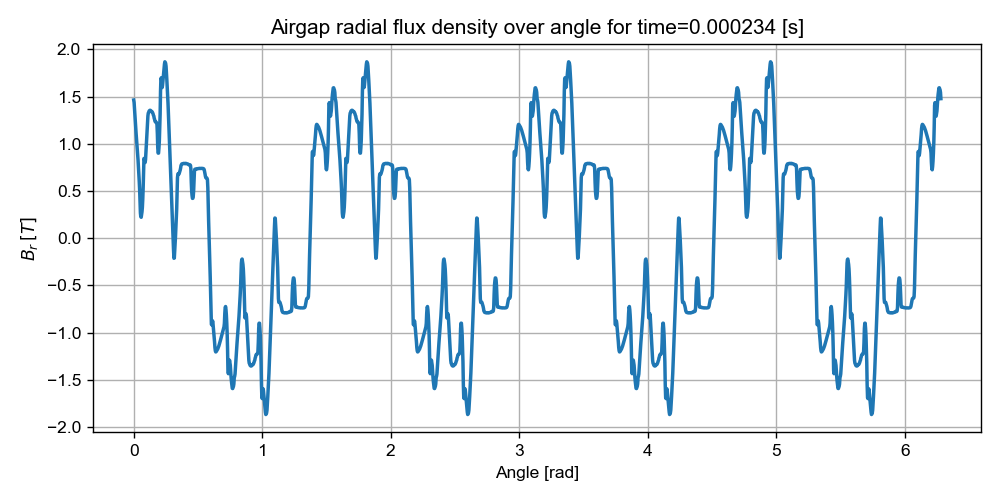

<IPython.core.display.Javascript object>


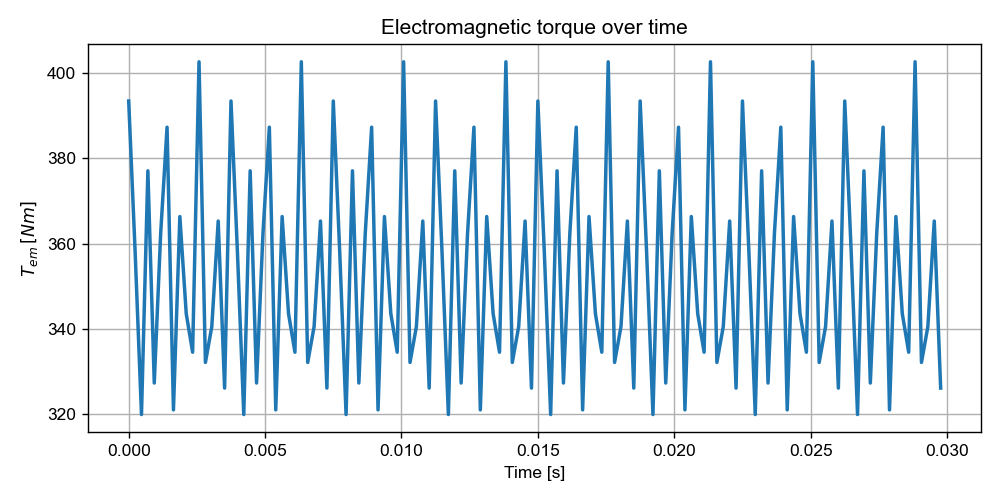

Torque values (with symmetry):
[393.46837092 358.31418124 319.93708077 377.08999416 327.32717196
 362.38149713 387.32507079 321.02512353 366.36776492 343.59091062
 334.55388602 402.66729442 332.14771862 340.57195356 365.31382858
 326.13705255]
Average Electromagnetic torque [N.m]:353.63868123514703
Peak to Peak Torque ripple [N.m]:82.7302136453659
Peak to Peak Torque ripple normalized according to average torque [-]:0.23393994502076432

Rotor speed [rpm]:2000
Id [Arms]:-135.4188051049254
Iq [Arms]:113.62986941801093


In [6]:
# Flux
output_ref.mag.B.plot_2D_Data("angle","time[1]",component_list=["radial"])

# Torque
output_ref.mag.Tem.plot_2D_Data("time")
print("Torque values (with symmetry):\n"+str(output_ref.mag.Tem.values))
print("Average Electromagnetic torque [N.m]:" +str(output_ref.mag.Tem_av))
print("Peak to Peak Torque ripple [N.m]:" +str(output_ref.mag.Tem_rip_pp))
print("Peak to Peak Torque ripple normalized according to average torque [-]:" +str(output_ref.mag.Tem_rip_norm))

# Operating point
print("\nRotor speed [rpm]:"+str(output_ref.elec.N0))
print("Id [Arms]:"+str(output_ref.elec.Id_ref))
print("Iq [Arms]:"+str(output_ref.elec.Iq_ref))

Although the Operation point was defined with I0/Phi0, pyleecan also store and use Id/Iq

## First multi-simulation layer: Variable speed

The next step is to define the variable speed simulation. This tutorial uses the results from: 
Z. Yang, M. Krishnamurthy and I. P. Brown, “Electromagnetic and vibrational characteristic of IPM over full torque-speed range,” 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp. 295-302, doi: 10.1109/IEMDC.2013.6556267.

Each pyleecan simulation is assumed to be quasi-static and run on a single operating point (fixed speed). To run a simulation on several operating points two steps are needed: First define a simulation that run correctly on a single operating point (like the one defined above), then define a VarLoadCurrent object. 

The VarLoadCurrent object is defined with a matrix with each line corresponding to an operating point and the column are:
- (N0, I0, Phi0) if type_OP_matrix==0
- (N0, Id, Iq) if type_OP_matrix==1

The following VarLoadCurrent object will run the previous simulation N_simu times by changing the value of Phi0. 

A fourth column can be added by setting is_torque=True. It enables to define the reference torque for the Operating Point. The reference is stored in output.elec.Tem_av_ref, the real computed torque is stored in output.mag.Tem_av.

Reference torque and current angle vector are:

In [7]:
from numpy import linspace, array, pi

Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_speed = Tem_av_ref.size

In [8]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange

varload = VarLoadCurrent(is_torque=True)
varload.type_OP_matrix = 0 # Matrix N0, I0, Phi0

# Creating the Operating point matrix
OP_matrix = zeros((N_speed,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_speed))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = 250/sqrt(2) * ones((N_speed)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref

varload.OP_matrix = OP_matrix
print(OP_matrix)

# All the simulation use the same machine
# No need to draw the machine for all OP
varload.is_reuse_femm_file=True  

[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]


This first layer will behave as follow:
- First the reference simulation will be run to get the reference output
- The reference simulation will be duplicated N_speed times with the value of InputCurrent updated according to the matrix. 
- is_reuse_femm will update the N_speed simulations to reuse the FEMM file drawn in the reference simulation to speed-up the computations.
- Each simulation of the list will be run separatly and the results gathered in an XOutput object

Pyleecan can detect that a simulation from the list matches the reference one and skip its computation to avoid computing twice the same thing. When defining a multi-simulation of multi-simulation, this optimization is essential since pyleecan will run "1 + (N_speed-1)" simulations instead of "1 + N_speed" for each combinaison of the design parameters. 

To further understand how pyleecan multi-simulation this tutorial use the option "is_keep_all_output" that keeps all the output of all the simulations. This option enables to access the plot for all the Operating Points but can take significant memory space depending on the simulation.

In [9]:
simu_vop = simu_ref.copy()
simu_vop.var_simu = varload
simu_vop.var_simu.is_keep_all_output = True

# Speed-up computation (set reference simu input as first OP), here reference is already the 9th simulation
# simu_vop.input.set_OP_from_array(varload.OP_matrix, varload.type_OP_matrix)

Xout_vop = simu_vop.run()

[23:50:22] Starting running simulation tuto_multi (machine=Toyota_Prius)
[23:50:22] Computing reference simulation for Variable Load
[23:50:22] Starting Magnetic module
[23:50:23] Solving time step 1 / 16 in FEMM
[23:50:24] Solving time step 5 / 16 in FEMM
[23:50:24] Solving time step 9 / 16 in FEMM
[23:50:25] Solving time step 13 / 16 in FEMM
[23:50:27] Solving time step 2 / 16 in FEMM
[23:50:27] Solving time step 6 / 16 in FEMM
[23:50:27] Solving time step 10 / 16 in FEMM
[23:50:28] Solving time step 14 / 16 in FEMM
[23:50:29] Solving time step 3 / 16 in FEMM
[23:50:30] Solving time step 7 / 16 in FEMM
[23:50:30] Solving time step 11 / 16 in FEMM
[23:50:30] Solving time step 15 / 16 in FEMM
[23:50:32] Solving time step 8 / 16 in FEMM
[23:50:32] Solving time step 4 / 16 in FEMM
[23:50:32] Solving time step 12 / 16 in FEMM
[23:50:32] Solving time step 16 / 16 in FEMM
[23:50:35] Variable Load Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [

[23:51:47] Solving time step 6 / 16 in FEMM
[23:51:48] Solving time step 14 / 16 in FEMM
[23:51:48] Solving time step 2 / 16 in FEMM
[23:51:50] Solving time step 11 / 16 in FEMM
[23:51:50] Solving time step 7 / 16 in FEMM
[23:51:50] Solving time step 15 / 16 in FEMM
[23:51:51] Solving time step 3 / 16 in FEMM
[23:51:52] Solving time step 8 / 16 in FEMM
[23:51:52] Solving time step 12 / 16 in FEMM
[23:51:53] Solving time step 16 / 16 in FEMM
[23:51:54] Solving time step 4 / 16 in FEMM
[23:51:56] Variable Load Results: N0=2000 [rpm], Id=-88.39 [Arms], Iq=153.1 [Arms], I0=176.8 [A], Phi0=2.094 [], Tem_av_ref=319 [N.m], Tem_av=323 [N.m], Tem_rip_pp=79.87 [N.m], Tem_rip_norm=0.2473 [-]
[============================                      ]  57%
[23:51:56] Running simulation 8/13 with N0=2000 [rpm], Id=-113.6 [Arms], Iq=135.4 [Arms]
[23:51:56] Starting Magnetic module
[23:51:57] Solving time step 1 / 16 in FEMM
[23:51:57] Solving time step 9 / 16 in FEMM
[23:51:57] Solving time step 5 / 16 in 

The log of the simulation enables to understand step by step the status of the computation. As expected, the reference simulation is computed first. Then each of the 13 simulations are run starting with a message indicating the simulation operating point:

**Running simulation 3/13 with N0=2000 [rpm], Id=30.7 [Arms], Iq=174.1 [Arms]**

And ending with the datakeepers result for this simulation:

**Variable Load Results: N0=2000 [rpm], Id=30.7 [Arms], Iq=174.1 [Arms], I0=176.8 [A], Phi0=1.396 [], Tem_av_ref=160 [N.m], Tem_av=170.3 [N.m], Tem_rip_pp=53.12 [N.m], Tem_rip_norm=0.312 [-]**

As expected the computation for the 9th simulation was skipped, the operating point and datakeepers are still displayed as a reminder.

Pyleecan will automatically define several Datakeeper to extract the main outputs from each simulation. These values are all gathered in the xoutput_dict:

In [10]:
print("Values available in XOutput:")
print(Xout_vop.xoutput_dict.keys())

print("\nI0 for each simulation:")
print(Xout_vop["I0"].result)
print("\nPhi0 for each simulation:")
print(Xout_vop["Phi0"].result)
print("\nComputed Average Torque for each simulation:")
print(Xout_vop["Tem_av"].result)
print("\nComputed Average Torque of the reference simulation:")
print(Xout_vop["Tem_av"].result_ref)

Values available in XOutput:
dict_keys(['N0', 'Id', 'Iq', 'I0', 'Phi0', 'Tem_av_ref', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm'])

I0 for each simulation:
[176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663683, 176.77669529663686]

Phi0 for each simulation:
[1.0471975511965976, 1.2217304763960306, 1.3962634015954636, 1.5707963267948966, 1.7453292519943295, 1.9198621771937625, 2.0943951023931957, 2.2689280275926285, 2.443460952792061, 2.6179938779914944, 2.7925268031909276, 2.9670597283903604, 3.141592653589793]

Computed Average Torque for each simulation:
[81.55656749041506, 125.37986740261135, 170.25385480916975, 214.24619913360607, 255.49305753085744, 292.4029759881057, 323.0316468839091, 344.94041471417665, 353.63868123514703, 337.85665706513726, 272.9202130539686, 154.64456490048806, -1.096036502090024

Other Datakeeper can be added in simu.var_simu.datakeeper_list to extract other meaningful (or user-defined) data.

As the option is_keep_all_output was activated, one can also access to all the simulation results in the "output_list":

Id: 30.69695099224322 , Iq: 174.0910600800047 , Tem_av_ref: 160.0


<IPython.core.display.Javascript object>


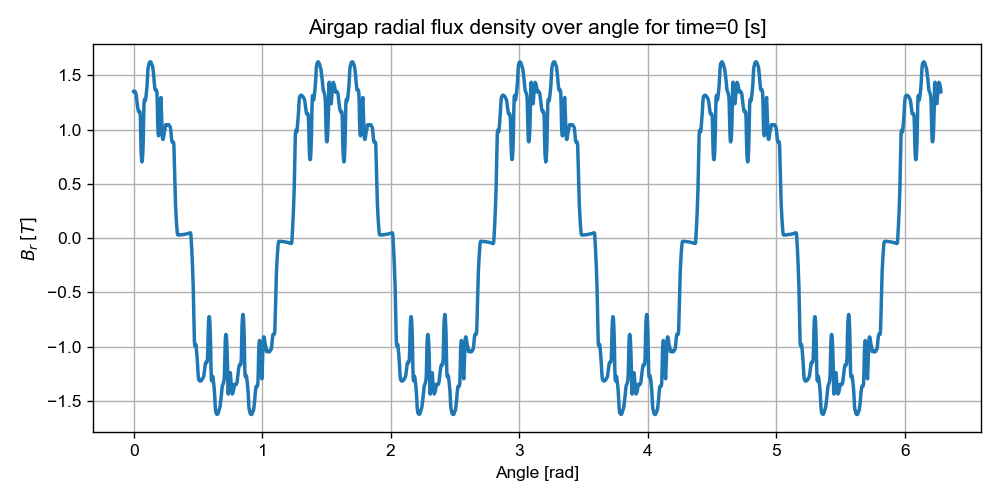

<IPython.core.display.Javascript object>


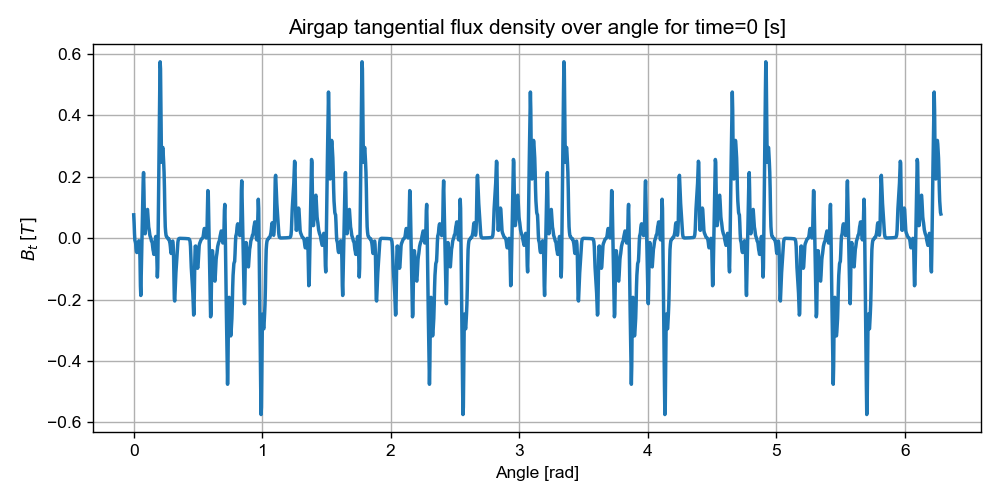

Index of the reference simulation in the list: 8
Id: -135.4188051049254 , Iq: 113.62986941801093 , Tem_av_ref: 353


<IPython.core.display.Javascript object>


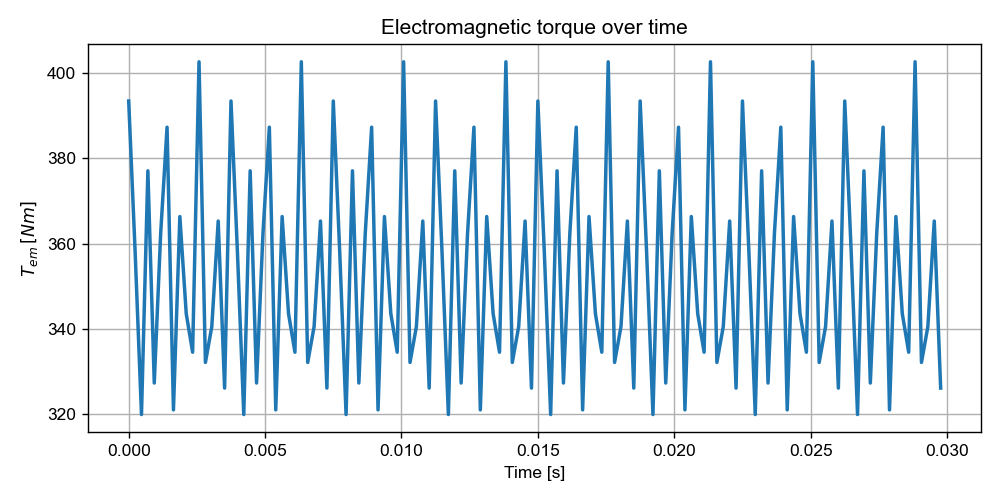

In [13]:
# Flux of the 3rd simulation
print("Id: "+str(Xout_vop.output_list[2].elec.Id_ref)+" , Iq: "+str(Xout_vop.output_list[2].elec.Iq_ref)+" , Tem_av_ref: "+str(Xout_vop.output_list[2].elec.Tem_av_ref))
Xout_vop.output_list[2].mag.B.plot_2D_Data("angle")

print("Index of the reference simulation in the list: "+str(Xout_vop.xoutput_ref_index))
print("Id: "+str(Xout_vop.output_list[8].elec.Id_ref)+" , Iq: "+str(Xout_vop.output_list[8].elec.Iq_ref)+" , Tem_av_ref: "+str(Xout_vop.output_list[8].elec.Tem_av_ref))
Xout_vop.output_list[8].mag.Tem.plot_2D_Data("time")

Any parameter in the XOutput can be plot as a function of any other

<IPython.core.display.Javascript object>


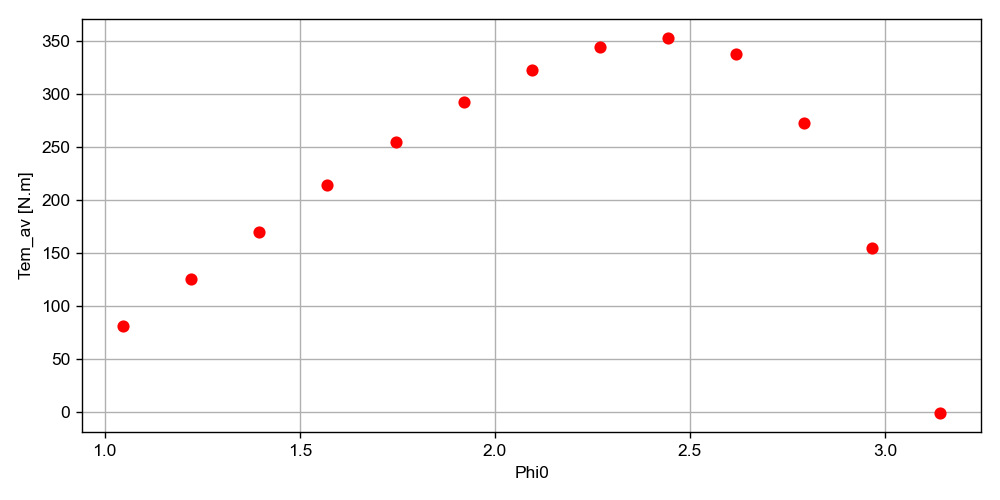

<IPython.core.display.Javascript object>


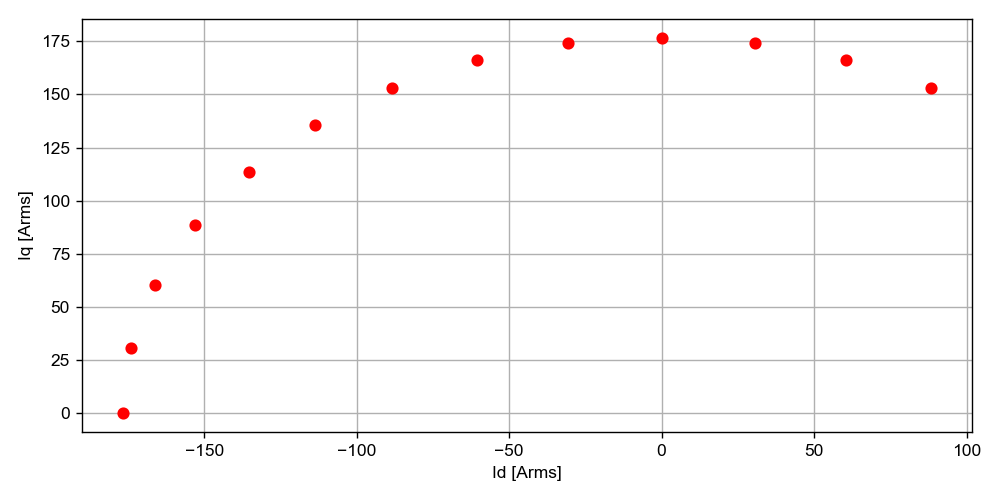

In [15]:
fig = Xout_vop.plot_multi("Phi0", "Tem_av")
fig = Xout_vop.plot_multi("Id", "Iq")

## Second multi-simulation layer only: Parameter Sweep

In pyleecan a Parameter Sweep is defined with a VarParam object. The design variables are set with ParamExplorer objects and the same Datakeeper as for a VarLoadCurrent (Id, Id, Tem_av...) will be automatically defined as output. Other Datakeepers can be defined in simu.var_simu.datakeeper_list.

VarParam and VarLoadCurrent inherit from the same class VarSimu. This is why most of the parameter of VarLoadCurrent are also available in VarParam and that the behavior of a VarParam is the same as a VarLoadCurrent. The main difference is how the simulation list is defined. Technicaly a VarLoadCurrent could be defined with a VarParam using ParamExplorer on Id/Iq/Tem_av_ref.

For this tutorial, only one ParamExplorer is defined: a linspace on the stator slot opening. The is_reuse_femm_file is desactivated as each simulation will have a different machine and is_keep_all_output is activated to show the full content of the xoutput object.

In [33]:
from pyleecan.Classes.VarParam import VarParam
from pyleecan.Classes.ParamExplorerInterval import ParamExplorerInterval

simu_sweep = simu_ref.copy()

# Multi-simulation to change machine parameters
sweep = VarParam(
    stop_if_error=True,
    is_reuse_femm_file=False,
    is_keep_all_output=True,
)
simu_sweep.var_simu = sweep

# List of ParamExplorer to define multisimulation input values
simu_sweep.var_simu.paramexplorer_list = [
    ParamExplorerInterval(
        name="Stator slot opening",
        symbol="W0s",
        unit="m",
        setter="simu.machine.stator.slot.W0",
        getter="simu.machine.stator.slot.W0",
        min_value=0.1 * Toyota_Prius.stator.slot.W0,
        max_value=1.4 * Toyota_Prius.stator.slot.W0,
        N=8,
    )
]

print("Value used in the Parameter sweep: "+str(simu_sweep.var_simu.paramexplorer_list[0].get_value()))
print("Reference machine W0: "+str(Toyota_Prius.stator.slot.W0))

Value used in the Parameter sweep: [0.000193   0.00055143 0.00090986 0.00126829 0.00162671 0.00198514
 0.00234357 0.002702  ]
Reference machine W0: 0.00193


In [19]:
Xout_sweep = simu_sweep.run()

[00:14:43] Starting running simulation tuto_multi (machine=Toyota_Prius)
[00:14:43] Computing reference simulation for Parameter Sweep
[00:14:43] W0s: 8 values from 0.000193 to 0.002316 (ref=0.00193) [m]
[00:14:43] Starting Magnetic module
[00:14:45] Solving time step 9 / 16 in FEMM
[00:14:45] Solving time step 1 / 16 in FEMM
[00:14:45] Solving time step 5 / 16 in FEMM
[00:14:46] Solving time step 13 / 16 in FEMM
[00:14:48] Solving time step 10 / 16 in FEMM
[00:14:48] Solving time step 2 / 16 in FEMM
[00:14:48] Solving time step 6 / 16 in FEMM
[00:14:48] Solving time step 14 / 16 in FEMM
[00:14:50] Solving time step 11 / 16 in FEMM
[00:14:50] Solving time step 3 / 16 in FEMM
[00:14:50] Solving time step 7 / 16 in FEMM
[00:14:51] Solving time step 15 / 16 in FEMM
[00:14:52] Solving time step 12 / 16 in FEMM
[00:14:52] Solving time step 8 / 16 in FEMM
[00:14:53] Solving time step 4 / 16 in FEMM
[00:14:53] Solving time step 16 / 16 in FEMM
[00:14:55] Parameter Sweep Reference Results: N0=

[============================================      ]  88%
[00:16:19] Running simulation 8/8 with W0s=0.002316
[00:16:19] Starting Magnetic module
[00:16:21] Solving time step 9 / 16 in FEMM
[00:16:21] Solving time step 1 / 16 in FEMM
[00:16:21] Solving time step 5 / 16 in FEMM
[00:16:22] Solving time step 13 / 16 in FEMM
[00:16:23] Solving time step 10 / 16 in FEMM
[00:16:24] Solving time step 2 / 16 in FEMM
[00:16:24] Solving time step 14 / 16 in FEMM
[00:16:24] Solving time step 6 / 16 in FEMM
[00:16:26] Solving time step 11 / 16 in FEMM
[00:16:26] Solving time step 3 / 16 in FEMM
[00:16:27] Solving time step 15 / 16 in FEMM
[00:16:27] Solving time step 7 / 16 in FEMM
[00:16:28] Solving time step 12 / 16 in FEMM
[00:16:28] Solving time step 4 / 16 in FEMM
[00:16:29] Solving time step 8 / 16 in FEMM
[00:16:29] Solving time step 16 / 16 in FEMM
[00:16:32] Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=354.1 [N.m], Tem_rip_pp=87.78 [N.m], Tem_rip_norm=

The log of the simulation enables to understand step by step the status of the computation. As expected, the reference simulation is computed first. Then each of the 8 simulations are run starting with a message indicating the simulation design variables:

**Running simulation 7/8 with W0s=0.0020127143**

And ending with the datakeepers result for this simulation:

**Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=353.8 [N.m], Tem_rip_pp=82.94 [N.m], Tem_rip_norm=0.2344 [-]**
    
When is_keep_all_output is True, the reference output is either stored in the output_list if one of the N simulation matches the reference one or in xoutput_ref otherwise

In [26]:
print("Xout_sweep.xoutput_ref:" +str(type(Xout_sweep.xoutput_ref)))
print("Xout_sweep.xoutput_ref_index:" +str(Xout_sweep.xoutput_ref_index))
print("\nXout_vop.xoutput_ref:" +str(Xout_vop.xoutput_ref))
print("Xout_vop.xoutput_ref_index:" +str(Xout_vop.xoutput_ref_index))

Xout_sweep.xoutput_ref:<class 'pyleecan.Classes.Output.Output'>
Xout_sweep.xoutput_ref_index:None

Xout_vop.xoutput_ref:None
Xout_vop.xoutput_ref_index:8


output_list, xoutput_dict and plot works the same way as for VarLoadCurrent. The ParamExplorer are also available in plot_multi:

<IPython.core.display.Javascript object>


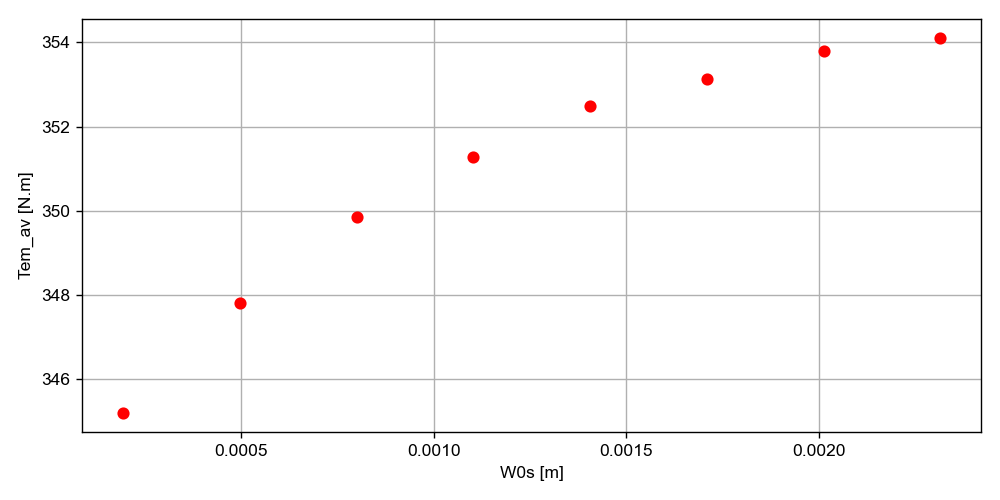

In [29]:
Xout_sweep.plot_multi("W0s","Tem_av")

As a reminder each output contains the simulation that computed it. In Parameter sweep with is_keep_all_output it enables to access each generated simulation and machine:

<IPython.core.display.Javascript object>


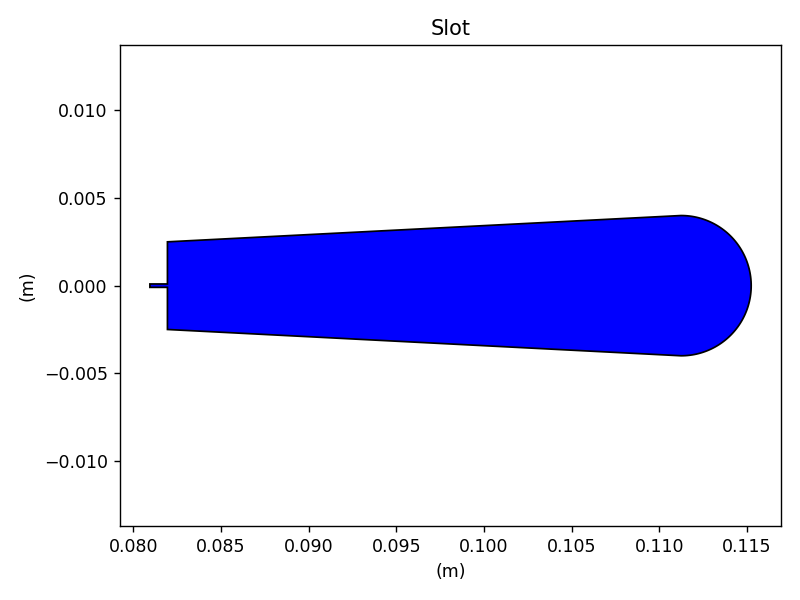

<IPython.core.display.Javascript object>


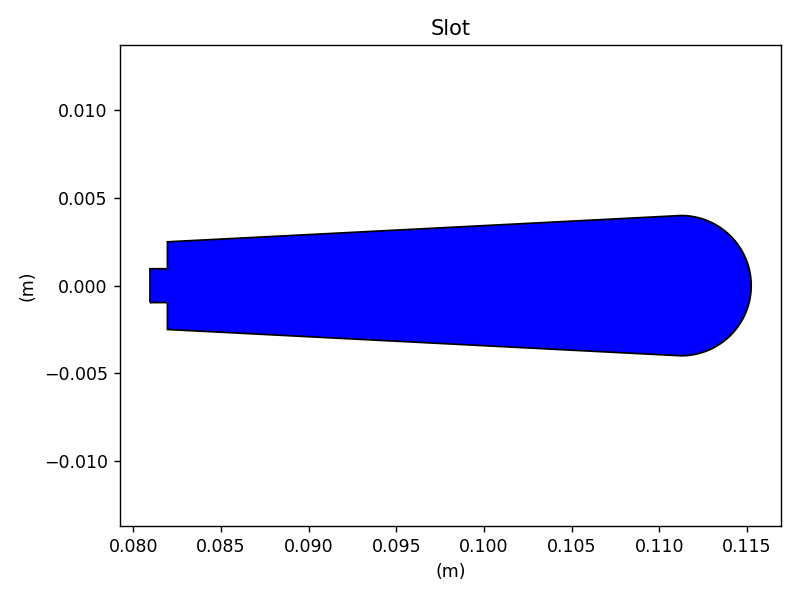

<IPython.core.display.Javascript object>


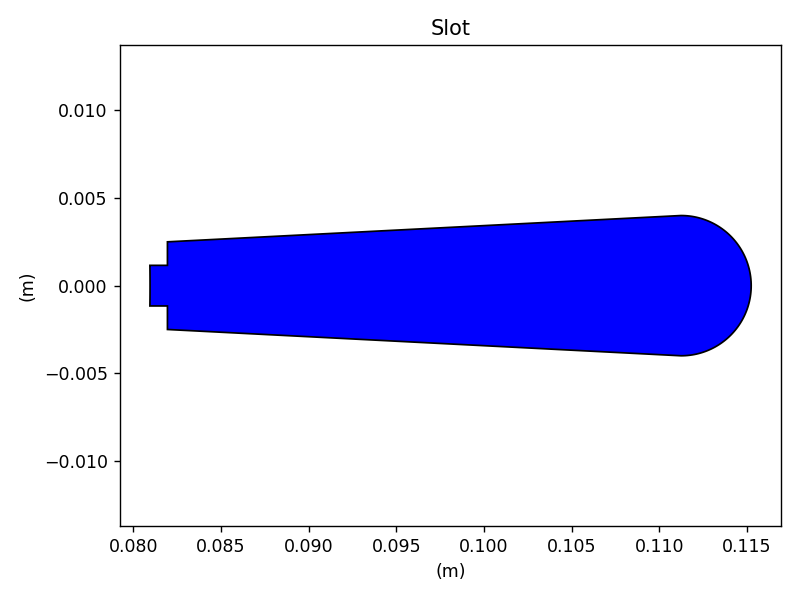

In [32]:
Xout_sweep.output_list[0].simu.machine.stator.slot.plot()
Xout_sweep.xoutput_ref.simu.machine.stator.slot.plot()
Xout_sweep.output_list[-1].simu.machine.stator.slot.plot()

# To save the simulation or machine for further modifications/computations
# Xout_sweep.output_list[-1].simu.save(path/to/json/file)
# Xout_sweep.output_list[-1].simu.machine.save(path/to/json/file)

## Both multi-simulation layers: Parameter-sweep of variable speed simulation